In [36]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

import pytreenet as ptn

In [37]:
def create_ttns(bond_dim: int) -> ptn.TreeTensorNetworkState:

    zero_state = np.asarray([1, 0])
    end_tensor = zero_state.reshape(1,2)
    end_tensor = np.pad(end_tensor, ((0, bond_dim-1), (0, 0)))
    chain_tensor = zero_state.reshape(1,1,2)
    chain_tensor = np.pad(chain_tensor, ((0, bond_dim-1),(0, bond_dim-1),(0, 0)))
    center_tensor = zero_state.reshape(1,1,1,2)
    center_tensor = np.pad(center_tensor, ((0, bond_dim-1),(0, bond_dim-1),(0, bond_dim-1),(0, 0)))
    ttns = ptn.TreeTensorNetworkState()
    center_node = ptn.Node(identifier="center")
    ttns.add_root(center_node, center_tensor)
    for i in range(3):
        chain_node = ptn.Node(identifier=f"chain_{i}")
        ttns.add_child_to_parent(chain_node, deepcopy(chain_tensor),
                                 0,"center",i)
        end_node = ptn.Node(identifier=f"end_{i}")
        ttns.add_child_to_parent(end_node, deepcopy(end_tensor),
                                 0,f"chain_{i}",1)
    return ttns

In [48]:
def create_problem_hamiltonian(ttn: ptn.TreeStructure, g: float) -> ptn.TTNO:
    X, _ , Z = ptn.pauli_matrices()
    nn_hamiltonian = ptn.create_nearest_neighbour_hamiltonian(ttn, "X",
                                                              conversion_dict={"X": X})
    local_hamiltonian = ptn.create_single_site_hamiltonian(ttn, "Z",
                                                            conversion_dict={"Z": g * Z})
    hamiltonian = ptn.Hamiltonian()
    hamiltonian.add_hamiltonian(nn_hamiltonian)
    hamiltonian.add_hamiltonian(local_hamiltonian)
    hamiltonian.conversion_dictionary["I2"] = np.eye(2)
    hamiltonian = hamiltonian.pad_with_identities(ttn)
    hamiltonian_ttno = ptn.TTNO.from_hamiltonian(hamiltonian, ttn)
    return hamiltonian_ttno

In [39]:
ttns_trivial_bond_dim = create_ttns(1)
ttns_high_bond_dim = create_ttns(5)
for node_id, node in ttns_trivial_bond_dim.nodes.items():
    print(node_id, node.shape)
print(20*"-")
for node_id, node in ttns_high_bond_dim.nodes.items():
    print(node_id, node.shape)

center (1, 1, 1, 2)
chain_0 (1, 1, 2)
end_0 (1, 2)
chain_1 (1, 1, 2)
end_1 (1, 2)
chain_2 (1, 1, 2)
end_2 (1, 2)
--------------------
center (5, 5, 5, 2)
chain_0 (5, 5, 2)
end_0 (5, 2)
chain_1 (5, 5, 2)
end_1 (5, 2)
chain_2 (5, 5, 2)
end_2 (5, 2)


In [40]:
hamiltonian = create_problem_hamiltonian(ttns_trivial_bond_dim, 0.5)
for node_id, node in hamiltonian.nodes.items():
    print(node_id, node.shape)

center (3, 3, 3, 2, 2)
chain_0 (3, 3, 2, 2)
end_0 (3, 2, 2)
chain_1 (3, 3, 2, 2)
end_1 (3, 2, 2)
chain_2 (3, 3, 2, 2)
end_2 (3, 2, 2)


In [41]:
_, _, Z = ptn.pauli_matrices()
operators = {identifier: ptn.TensorProduct({identifier: Z}) for identifier in ttns_trivial_bond_dim.nodes.keys()}
for operator in operators.values():
    print(operator)

{'center': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'chain_0': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'end_0': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'chain_1': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'end_1': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'chain_2': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'end_2': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}


In [42]:
time_steps_size = 0.001
final_time = 1
truncation_parameters = {"max_bond_dim": 8,
                         "rel_tol": 1e-8,
                         "total_tol": 1e-8}

In [51]:
# Reference Computation
ref_state = [0] * (2 ** len(ttns_trivial_bond_dim.nodes))
ref_state[0] = 1
ref_state = np.asarray(ref_state)

ref_ham, order = hamiltonian.completely_contract_tree(to_copy=True)
ref_operators = {identifier: 1 for identifier in order}
for current_id in order:
    for identifier, operator in ref_operators.items():
        if current_id == identifier:
            ref_operators[identifier] = np.kron(operator,Z)
        else:
            ref_operators[identifier] = np.kron(operator,np.eye(2))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 1)

In [43]:
tdvp1 = ptn.SecondOrderOneSiteTDVP(ttns_high_bond_dim, hamiltonian,
                                   time_steps_size, final_time,
                                   operators, record_bond_dim=True)
tdvp2 = ptn.SecondOrderTwoSiteTDVP(ttns_trivial_bond_dim, hamiltonian,
                                   time_steps_size, final_time,
                                   operators, truncation_parameters=truncation_parameters,
                                   record_bond_dim=True)

In [44]:
tdvp1.run()
tdvp2.run()

  1%|          | 8/1001 [00:00<00:38, 26.07it/s]

100%|██████████| 1001/1001 [00:44<00:00, 22.55it/s]


In [45]:
# Sanity check
print(f"1TDVP results are real: {tdvp1.results_real()}")
print(f"2TDVP results are real: {tdvp2.results_real()}")

1TDVP results are real: True
2TDVP results are real: True


In [46]:
times = tdvp1.times()
tdvp1_result_center = tdvp1.operator_result("center", realise=True)
tdvp1_bond_dim = tdvp1.operator_result("bond_dim")[('center', 'chain_1')]
tdvp2_result_center = tdvp2.operator_result("center", realise=True)
tdvp2_bond_dim = tdvp2.operator_result("bond_dim")[('center', 'chain_1')]

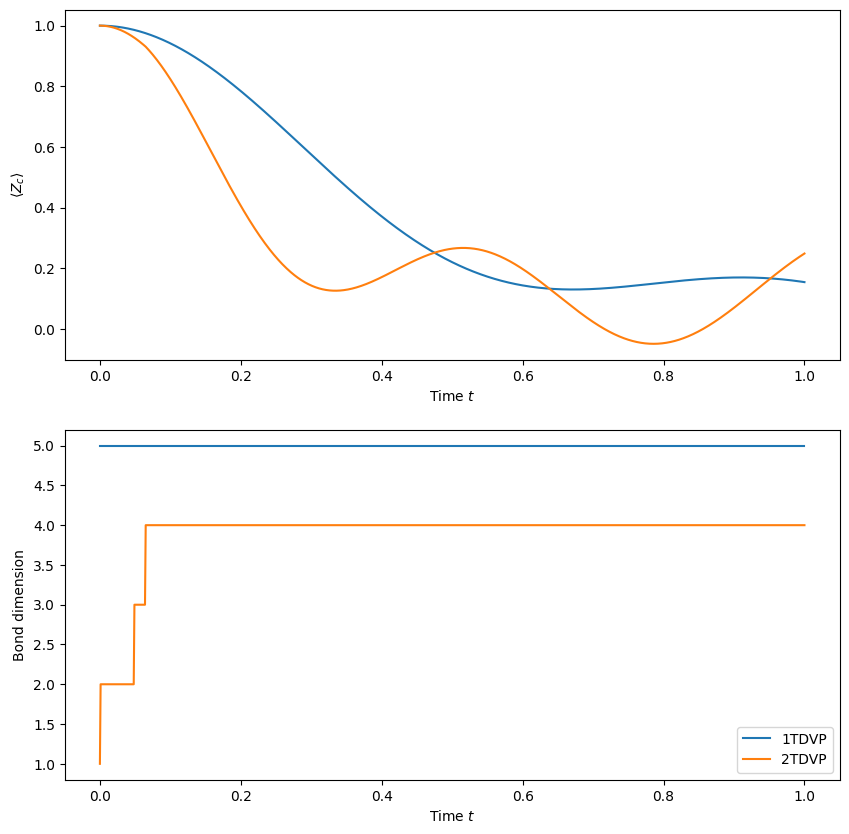

In [47]:
fig_bd, ax_bd = plt.subplots(2,1, figsize=(10,10))

ax_bd[0].plot(times, tdvp1_result_center, label="1TDVP")
ax_bd[0].plot(times, tdvp2_result_center, label="2TDVP")
ax_bd[0].set_xlabel("Time $t$")
ax_bd[0].set_ylabel(r"$\langle Z_c \rangle$")

ax_bd[1].plot(times, tdvp1_bond_dim, label="1TDVP")
ax_bd[1].plot(times, tdvp2_bond_dim, label="2TDVP")
ax_bd[1].set_xlabel("Time $t$")
ax_bd[1].set_ylabel("Bond dimension")

plt.legend()
plt.show()